# Apply PCM to CMCC temperature data run

Apply PCM method to CMCC temperature data run (example for a 3D gridded product other than ISAS). Notebook developped in local

In [42]:
import xarray as xr
import numpy as np

import pyxpcm
from pyxpcm.models import pcm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import seaborn as sns

from Plotter import Plotter #new class for plots in pyxpcm

## Get data
***

In [13]:
ds_path = "/home/ref-oc-intranet/cmcc_mfseas4/best_estimate/2020/CMCC_MFSEAS-4_20200611_TEMP.nc"
ds_path

'/home/ref-oc-intranet/cmcc_mfseas4/best_estimate/2020/CMCC_MFSEAS-4_20200611_TEMP.nc'

In [14]:
ds = xarray.open_dataset(ds_path)
ds['depth'] = -np.abs(ds['depth'].values) # Ensure depth axis is negative

In [30]:
ds

<xarray.Dataset>
Dimensions:     (depth: 141, lat: 380, lon: 1287, pcm_class: 8, quantile: 3, time: 1)
Coordinates:
  * pcm_class   (pcm_class) int64 0 1 2 3 4 5 6 7
  * depth       (depth) float32 -1.0182366 -3.1657474 ... -5646.199 -5754.044
  * lat         (lat) float64 30.19 30.23 30.27 30.31 ... 45.85 45.9 45.94 45.98
  * lon         (lon) float64 -17.29 -17.25 -17.21 -17.17 ... 36.21 36.25 36.29
  * time        (time) datetime64[ns] 2020-06-11
  * quantile    (quantile) float64 0.05 0.5 0.95
Data variables:
    bottomT     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    thetao      (time, depth, lat, lon) float32 nan nan nan nan ... nan nan nan
    PCM_LABELS  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    PCM_POST    (pcm_class, time, lat, lon) float64 nan nan nan ... nan nan nan
    thetao_Q    (pcm_class, quantile, depth) float64 18.5 18.3 18.13 ... nan nan
Attributes:
    comment:        Please check in CMEMS catalogue the INFO section for prod...
    field_type:     daily_mean_centered_at_time_field
    title:          Potential Temperature (3D) - Daily Mean
    Conventions:    CF-1.0
    source:         MFS EAS4
    contact:        servicedesk.cmems@mercator-ocean.eu
    references:     Please check in CMEMS catalogue the INFO section for prod...
    bulletin_type:  analysis
    bulletin_date:  20200601
    institution:    Centro Euro-Mediterraneo sui Cambiamenti Climatici - CMCC...
    history:        Tue Jun  2 00:48:52 2020: ncks -4 -L 1 /home/datawork-oco...
    NCO:            4.0.3

## Applying PCM
***

### Create PCM

Choise of z (very important to make a good choise) 

In [15]:
# z = np.arange(0.,-1000,-10.)
# z = np.linspace(min(ds.depth.values),max(ds.depth.values), num = ds.depth.size)
z = ds['depth'][0:20]
pcm_features = {'temperature': z}
z

<xarray.DataArray 'depth' (depth: 20)>
array([ -1.018237,  -3.165747,  -5.464963,  -7.920377, -10.536604, -13.318384,
       -16.270586, -19.39821 , -22.706392, -26.2004  , -29.885643, -33.767673,
       -37.852192, -42.14504 , -46.65221 , -51.37986 , -56.334286, -61.521957,
       -66.94949 , -72.62369 ], dtype=float32)
Coordinates:
  * depth    (depth) float32 -1.0182366 -3.1657474 ... -66.94949 -72.62369

instantiate the PCM

In [16]:
m = pcm(K=8, features=pcm_features)
m

<pcm 'gmm' (K: 8, F: 1)>
Number of class: 8
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

### Fit Model

In [17]:
features_in_ds = {'temperature': 'thetao'}
features_zdim='depth'
m.fit(ds, features=features_in_ds, dim=features_zdim)
m

<pcm 'gmm' (K: 8, F: 1)>
Number of class: 8
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 28.904383

### Classify data

In [19]:
m.predict(ds, features=features_in_ds, dim=features_zdim, inplace=True);
#ds

In [20]:
m.predict_proba(ds, features=features_in_ds, dim=features_zdim, inplace=True);
#ds

In [22]:
ds = ds.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of='thetao', outname='thetao' + '_Q', keep_attrs=True, inplace=True)
# TODO: generic name for the variable
#ds

/export/home1/agarciaj/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1392: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


## Visualisation
***

In [43]:
P = Plotter(ds.squeeze(), m, data_type = 'gridded')

#### 1. Vertical structure of classes

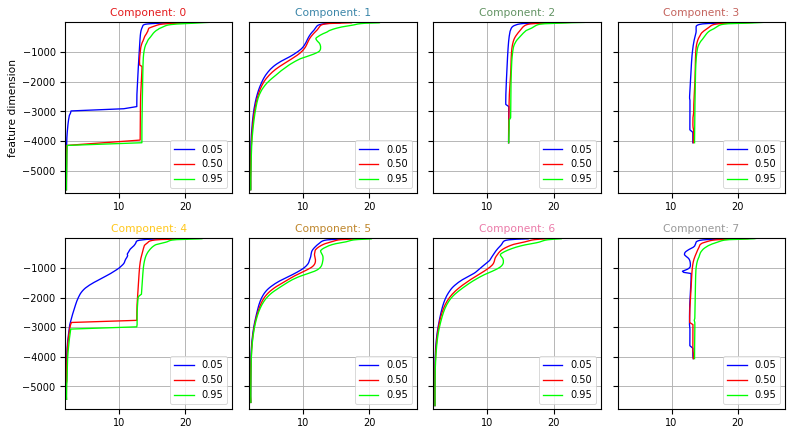

In [27]:
P.vertical_structure(q_variable = 'thetao_Q')

#### 2. Spatial distribution of classes

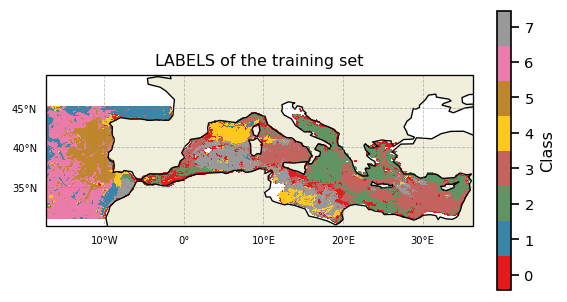

In [44]:
#change extent (calculate extent max in plotter class?)

extent = np.array([min(ds.lon), max(ds.lon), min(ds.lat), max(ds.lat)]) + np.array([-0.1,+0.1,-0.1,+0.1])
P.spatial_distribution(proj=ccrs.PlateCarree(), 
                       extent=extent, 
                       co = {'latitude':'lat', 'longitude':'lon'})

#### 3. Posteriors

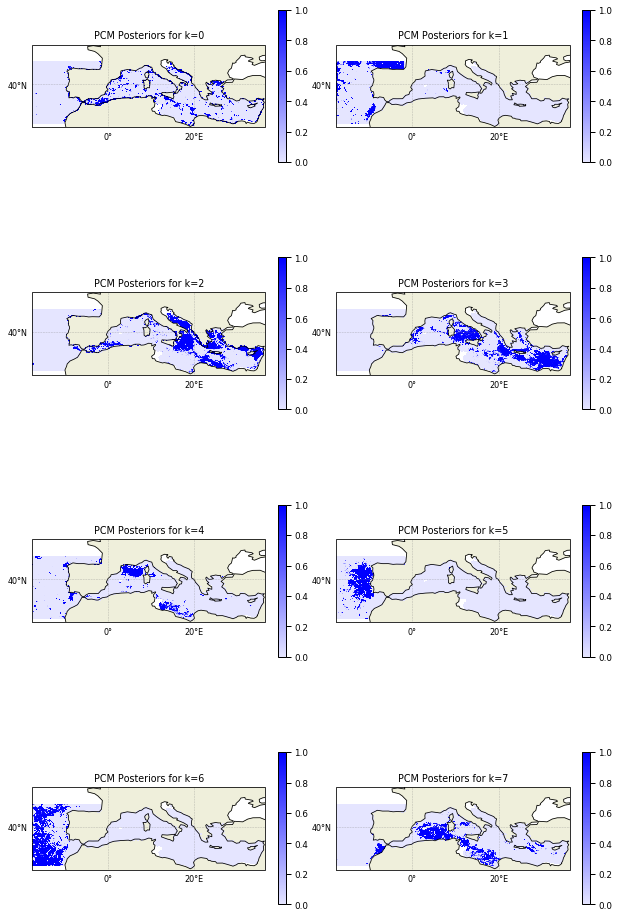

In [45]:
P.plot_posteriors(proj=ccrs.PlateCarree(), extent=extent, 
                       co = {'latitude':'lat', 'longitude':'lon'})

#### 4. Temporal representation 

<font color=red>__TODO__</font> : Temporal representation in class plotter for 3D gridded data